In [20]:
%matplotlib inline

import math
import random

import matplotlib.pyplot as plt
import numpy as np

In [43]:
L = 4 # system size in one direction
J = 1 # lattice bond energy
temperature = 2 # temperature to simulate
beta = 1/temperature # inverse temperature, setting Boltzmann constant to 1

sweeps = 10000

lattice = np.random.choice([-1, 1], L*L).reshape(L, L) # infinite initial temperature
print(lattice)

magnetization = np.sum(lattice)
print(magnetization)

[[-1  1  1 -1]
 [ 1 -1  1 -1]
 [-1  1 -1 -1]
 [ 1 -1  1  1]]
0


In [44]:
def calculate_energy(lattice):
    """Calculate the energy of a lattice using the Ising model Hamiltonian."""
    energy = 0
    for y in range(L):
        for x in range(L):
            center = lattice[y][x]
            neighbours = [(y, (x-1)%L) ,(y, (x+1)%L), ((y-1)%L, x), ((y+1)%L, x)]
            for n in neighbours:
                if lattice[n] == center:
                    energy += J
        
    return energy
                    
            

energy = calculate_energy(lattice)
print(energy)

20


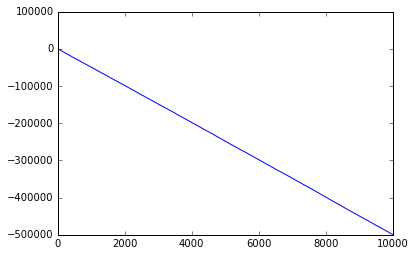

In [47]:
energy_history = []

energy = calculate_energy(lattice)
# print(energy)
for t in range(sweeps):
    for k in range(L*L):
        rand_y, rand_x = (random.randrange(L), random.randrange(L))
        spin = lattice[rand_y, rand_x]
        neighbours = [(rand_y, (rand_x-1)%L) ,(rand_y, (rand_x+1)%L), ((rand_y-1)%L, rand_x), ((rand_y+1)%L, rand_x)]
        spin_sum = 0
        for n in neighbours:
            spin_sum += lattice[n]
        energy_delta = 2*J*spin*spin_sum
#         print(energy_delta)
        acceptance_probability = min(1, math.exp(-beta*energy_delta))
#         print(acceptance_probability)
        if random.random() <= acceptance_probability:
            np.put(lattice, [rand_y, rand_x], -1*spin)
            energy += energy_delta
#             print(energy)
        energy_history.append((t+k/(L*L), energy))

# print(energy_history)
plt.plot([x[0] for x in energy_history], [y[1] for y in energy_history])
plt.show()
            